# Demo of `gcdyn.mutators.DiscreteMutator`

In [1]:
from gcdyn import bdms, model, mutators
from numpy import pi, sqrt
import numpy as np
import matplotlib.pyplot as plt
from ete3.coretype.tree import TreeError

## Simulation

In [2]:
θ = [2, 1, 0, 0]

state_space = [1.0, 2.7, sqrt(2), pi]

transition_matrix = [
    [0,    0,    0,    1],
    [0.25, 0.25, 0.25, 0.25],
    [0.8,  0.1,  0.05, 0.05],
    [0.5,  0.25, 0.25, 0]
]

In [3]:
tree = bdms.TreeNode(x = 2.7)
tree.evolve(
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = mutators.DiscreteMutator(state_space, transition_matrix),
    min_survivors = 20,
    seed = 0
)
tree.sample_survivors(p = 0.5, seed = 0)

In [4]:
print(tree.x)
print([c.x for c in tree.children[0].children])

2.7
[2.7, 1.4142135623730951]


In [5]:
for node in tree.traverse():
    for child in node.children:
        if child.event != "mutation":
            continue
        
        if node.x == 1.0:
            assert child.x == pi
        
        if node.x == pi:
            assert child.x != pi

## Inference

In [6]:
def plot_curve(*θ_values, range = (-10, 10), **named_θ_values):
    x_array = np.linspace(*range)
    λ = lambda θ: model.Model.λ(None, x_array, θ)

    plt.figure()

    for θ in θ_values:
        plt.plot(x_array, λ(θ), color = "black", alpha = 0.5)

    for name, θ in named_θ_values.items():
        plt.plot(x_array, λ(θ), label = name)
    
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\lambda_\theta(x)$")
    plt.xlim(*range)
    
    if named_θ_values:
        plt.legend()

    plt.show()


def evolve_trees(num_trees, init_x = 0, **evolve_kwargs):
    trees = []
    seed = evolve_kwargs.pop("seed", None)

    for _ in range(num_trees):
        while True:
            try:
                tree = bdms.TreeNode(x = init_x)
                tree.evolve(seed = seed, **evolve_kwargs)
                trees.append(tree)
                break

            except TreeError: # not enough survivors
                seed = seed + 1 if seed is not None else None

        seed = seed + 1 if seed is not None else None

    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")

    return trees


def prune_trees(trees):
    copied_trees = [tree.copy() for tree in trees]

    for tree in copied_trees:
        tree.prune()

    return copied_trees

Generate some trees, and obtain pruned copies

In [7]:
trees = evolve_trees(10,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = mutators.DiscreteMutator(state_space, transition_matrix),
    min_survivors = 20,
    seed = 0,
    init_x = 2.7
)
for tree in trees:
    tree.sample_survivors(p = 0.5, seed = 0)

pruned_trees = prune_trees(trees)

fully_observed_model = model.Model(trees, μ = 1, γ = 1, ρ = 0.5)
pruned_model = model.Model(pruned_trees, μ = 1, γ = 1, ρ = 0.5)

Average of 540.5 nodes per tree, over 10 trees


Obtain the MLE using both sets of trees

In [8]:
print(f"Truth: {θ}")

full_result = fully_observed_model.fit()
print(f"Solution in {full_result.state.iter_num} iterations: {full_result.params}")

pruned_result = pruned_model.fit()
print(f"Solution in {pruned_result.state.iter_num} iterations after pruning: {pruned_result.params}")

Truth: [2, 1, 0, 0]


2022-10-20 15:19:25.504822: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_.0] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-10-20 15:20:45.921793: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4m57.626092s

********************************
[Compiling module jit__lambda_.0] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Solution in 5 iterations: [2.0194778  0.9874627  0.46307066 0.07669576]
Solution in 14 iterations after pruning: [1.6054163 0.5094492 5.806284  0.5569387]


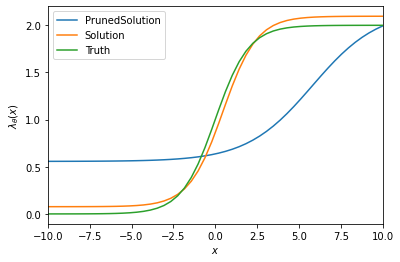

In [9]:
plot_curve(PrunedSolution = pruned_result.params, Solution = full_result.params, Truth = θ)

Also, to gain some visualization of uncertainty, obtain the MLE using each individual pruned tree

In [10]:
individual_pruned_results = []

for tree in pruned_trees:
    # Because of JIT, you need to build a new model with the modified trees
    individual_model = model.Model([tree], μ = 1, γ = 1, ρ = 0.5)

    result = individual_model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
    print(f"Solution in {result.state.iter_num} iterations after pruning (individual): {result.params}")

    individual_pruned_results.append(result)

Solution in 3 iterations after pruning (individual): [ 0.89031863 -5.8805313   3.854872    0.        ]
Solution in 50 iterations after pruning (individual): [1.5667886  8.61498    2.7965908  0.22211882]
Solution in 46 iterations after pruning (individual): [ 0.37218264 14.887911    2.1024911   0.66833246]
Solution in 5 iterations after pruning (individual): [1.3078843  0.13028368 0.5197167  0.        ]
Solution in 43 iterations after pruning (individual): [ 0.6572415  10.115119    2.4454768   0.32755217]
Solution in 10 iterations after pruning (individual): [ 1.7200907  -0.03212034  0.65289736  0.00683354]
Solution in 37 iterations after pruning (individual): [9.1544664e-01 8.0170364e+00 1.1494516e+00 2.3422999e-07]
Solution in 10 iterations after pruning (individual): [ 1.7266752e+00 -6.0442884e-02  5.1063955e-01  5.6698607e-10]
Solution in 9 iterations after pruning (individual): [  0.22785893 -21.982557    12.231394     0.34427366]
Solution in 62 iterations after pruning (individual

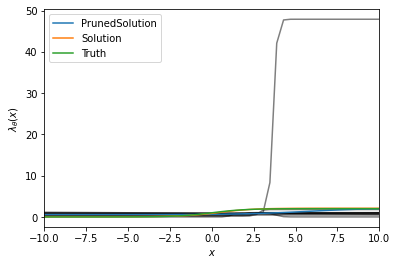

In [11]:
plot_curve(*[mle.params for mle in individual_pruned_results], PrunedSolution = pruned_result.params, Solution = full_result.params, Truth = θ)

Ignoring that extreme curve:

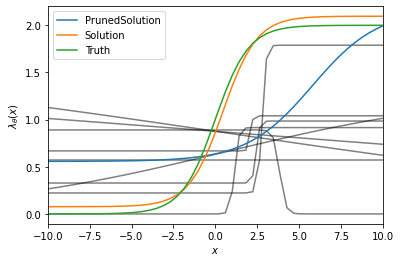

In [12]:
plot_curve(*[mle.params for mle in individual_pruned_results][:-1], PrunedSolution = pruned_result.params, Solution = full_result.params, Truth = θ)